# Mxnet Data Iterator .rec with shuffle

In [1]:
import mxnet as mx
import sys, os
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2
import pandas as pd
import re
from mxnet.io import DataIter
from mxnet.io import DataBatch
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from collections import namedtuple
import pickle

Batch = namedtuple('Batch', ['data'])

BATCH_SIZE,INPUT_SIZE_z,INPUT_SIZE_y, INPUT_SIZE_x = 8,32,32,32
def print_inferred_shape(net):
    ar, ou, au = net.infer_shape(data=(BATCH_SIZE, 1, INPUT_SIZE_z,INPUT_SIZE_y, INPUT_SIZE_x))
    print(net.name,ou)

In [2]:
class FileIter2(DataIter):
    def __init__(self, path,path_idx,
                 data_name="data",
                 label_name="softmax_label",
                 batch_size=1,
                 do_augment=False,
                 mean_image=.2815,
                 std_image = .2807):

        
        random.seed(313)
        self.epoch = 0
        self.mean_image = mean_image
        self.std_image = std_image
        
        super(FileIter2, self).__init__()
        self.batch_size = batch_size
        self.do_augment=do_augment
        

        self.data_name = data_name
        self.label_name = label_name

        self.record = mx.recordio.MXIndexedRecordIO(path_idx, path, 'r')#mx.recordio.MXRecordIO(path, 'r')

        
        def readrecord(record):
            record.reset()
            num_data=0
            while True:
                item = record.read()
                num_data+=1
                if not item:
                    break
            return num_data-1
        
        
        self.num_data = readrecord(self.record)#len(open(self.flist_name, 'r').readlines())
        
        
        
        self.idx = self.shuffle_idx()
        self.cursor = -1
        self.cursor2 = -1
        self.ind = self.idx[0]
        self.record.reset()

        self.data, self.label = self._read()
        self.reset()
            
    def shuffle_idx(self):
        num_data = self.num_data//self.batch_size*self.batch_size
        idx = [i for i in range(num_data)]
        random.shuffle(idx)
        idx = np.array(idx)
        idx = idx.reshape(-1,self.batch_size)
        return idx
    
    def _read(self):
        """get two list, each list contains two elements: name and nd.array value"""
                
        data = {}
        label = {}

        dd = []
        ll = []
        ind = self.ind
        for i in range(0, self.batch_size):
            
            item = self.record.read_idx(ind[i])            
            header, l = mx.recordio.unpack_img(item)
            
            d=header.label

            d=d.reshape((32,32,32))- self.mean_image
            d = d/self.std_image
            d = np.expand_dims(d, axis=0) 
            d = np.expand_dims(d, axis=0)
            

            l=l.reshape((32*32*32))
            l = np.expand_dims(l, axis=0)
            l=l.astype(float)

            dd.append(d)
            ll.append(l)

        d = np.vstack(dd)
        l = np.vstack(ll)
        data[self.data_name] = d
        label[self.label_name] = l
        res = list(data.items()), list(label.items())
        return res

    @property
    def provide_data(self):
        """The name and shape of data provided by this iterator"""
        res = [(k, tuple(list(v.shape[0:]))) for k, v in self.data]
        # print "data : " + str(res)
        return res

    @property
    def provide_label(self):
        """The name and shape of label provided by this iterator"""
        res = [(k, tuple(list(v.shape[0:]))) for k, v in self.label]
        return res
    

    def reset(self):
        self.cursor = -1
        self.cursor2 = -1
        self.record.reset()
        self.epoch += 1
        self.idx = self.shuffle_idx()
        


    def getpad(self):
        return 0

    def iter_next(self):
        self.cursor += self.batch_size
        self.cursor2 += 1
        self.ind = self.idx[self.cursor2]

        if self.cursor < self.num_data:
            return True
        else:
            return False

    def eof(self):
        res = self.cursor >= self.num_data
        return res

    def next(self):
        """return one dict which contains "data" and "label" """
        if self.iter_next():
            self.data, self.label = self._read()
 
            res = DataBatch(data=[mx.nd.array(self.data[0][1])], label=[mx.nd.array(self.label[0][1])], pad=self.getpad(), index=None)

            return res
        else:
            raise StopIteration


In [25]:
interm_dir4='/home/mas/x110/data'
train_data_path=interm_dir4+'/Train23Oct2018augment.rec'
train_idx_path=interm_dir4+'/idx_Train23Oct2018augment.idx'
BATCH_SIZE=5
train_iter=FileIter2(train_data_path,train_idx_path,batch_size=BATCH_SIZE)

In [26]:
train_iter.reset()

In [27]:
train_iter.idx

array([[51, 49, 27, 50, 25],
       [40, 57, 23, 47,  4],
       [37, 18, 12, 44, 29],
       [13, 11, 26,  1, 59],
       [ 7, 24, 10, 53, 45],
       [36, 41, 33, 14, 32],
       [15, 35, 21, 43, 30],
       [ 3, 48, 39,  2, 58],
       [52, 38, 46,  6, 31],
       [28, 19, 55,  0, 34],
       [56, 54,  8, 42, 17],
       [ 5, 22,  9, 16, 20]])

In [59]:
train_iter.ind

array([37, 18, 12, 44, 29])

In [29]:
batch.data[0].shape

(5, 1, 32, 32, 32)

In [30]:
batch.label[0][0].shape

(32768,)

In [58]:
batch = train_iter.next()

In [60]:
k=2
X =  batch.data[0][k][0].asnumpy()
Y = batch.label[0][k].reshape((32,32,32)).asnumpy()

In [61]:
X.shape,Y.shape

((32, 32, 32), (32, 32, 32))

In [62]:
x_std, x_mean =[train_iter.std_image,train_iter.mean_image]

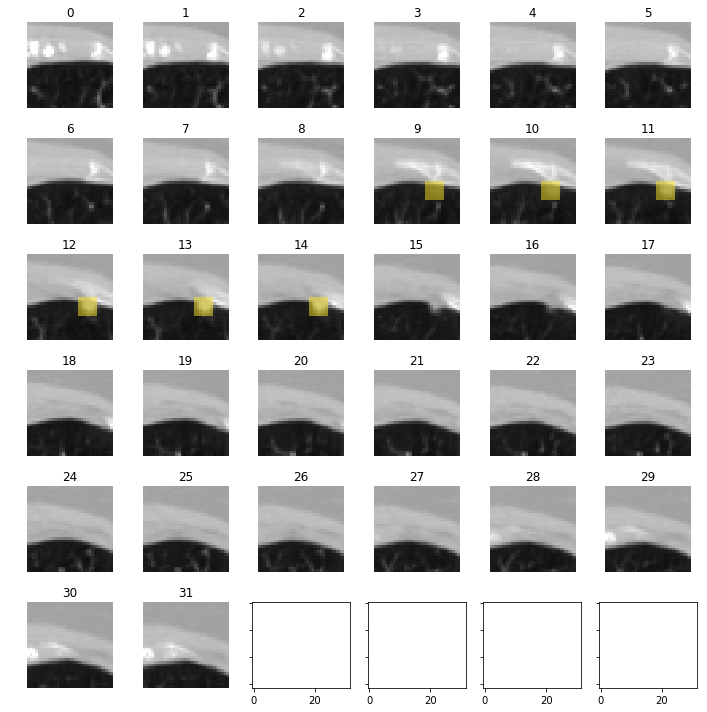

In [63]:
zs=32
X = X*x_std+x_mean
X2,Z2 = X,Y
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=6
num_cols=6

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(10,10))

ind=np.arange(0,32)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.5,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title(str(ii))
      
plt.tight_layout()

In [ ]:
data_P_23_288_159_130.pkl